## Prediction of accident number by category and time
#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pickle
from neuralprophet import NeuralProphet, save, load
import itertools
import logging
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

/u/halle/zhouni/home_at/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


#### Load dataset
The number of accidents for different categories per month.

In [2]:
df = pd.read_csv('./data/monatszahlen2307_verkehrsunfaelle_10_07_23_nosum.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   MONATSZAHL                      2016 non-null   object 
 1   AUSPRAEGUNG                     2016 non-null   object 
 2   JAHR                            2016 non-null   int64  
 3   MONAT                           2016 non-null   int64  
 4   WERT                            1848 non-null   float64
 5   VORJAHRESWERT                   1848 non-null   float64
 6   VERAEND_VORMONAT_PROZENT        1840 non-null   float64
 7   VERAEND_VORJAHRESMONAT_PROZENT  1763 non-null   float64
 8   ZWOELF_MONATE_MITTELWERT        1848 non-null   float64
dtypes: float64(5), int64(2), object(2)
memory usage: 141.9+ KB


#### Data cleaning
Drop NaNs in "WERT".

In [3]:
df.dropna(axis=0, subset=['WERT'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1848 entries, 0 to 1847
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   MONATSZAHL                      1848 non-null   object 
 1   AUSPRAEGUNG                     1848 non-null   object 
 2   JAHR                            1848 non-null   int64  
 3   MONAT                           1848 non-null   int64  
 4   WERT                            1848 non-null   float64
 5   VORJAHRESWERT                   1764 non-null   float64
 6   VERAEND_VORMONAT_PROZENT        1840 non-null   float64
 7   VERAEND_VORJAHRESMONAT_PROZENT  1763 non-null   float64
 8   ZWOELF_MONATE_MITTELWERT        1848 non-null   float64
dtypes: float64(5), int64(2), object(2)
memory usage: 130.1+ KB


Check for duplicates.

In [5]:
print(df.duplicated().any())

False


Convert the format of "MONAT" to datetime.

In [4]:
df['MONAT'] = pd.to_datetime(df['MONAT'], format='%Y%m', errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1848 entries, 0 to 1847
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   MONATSZAHL                      1848 non-null   object        
 1   AUSPRAEGUNG                     1848 non-null   object        
 2   JAHR                            1848 non-null   int64         
 3   MONAT                           1848 non-null   datetime64[ns]
 4   WERT                            1848 non-null   float64       
 5   VORJAHRESWERT                   1764 non-null   float64       
 6   VERAEND_VORMONAT_PROZENT        1840 non-null   float64       
 7   VERAEND_VORJAHRESMONAT_PROZENT  1763 non-null   float64       
 8   ZWOELF_MONATE_MITTELWERT        1848 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 130.1+ KB


#### Data preprocessing
Split data into train and test set (train set: all data before 2020, test set: data after 2020).

In [13]:
data = df.copy()

data_train = data[data['MONAT'] < '2021-01-01']
data_train.reset_index(drop=True, inplace=True)
print(data_train.shape)

data_test = data[data['MONAT'] >= '2021-01-01']
data_test.reset_index(drop=True, inplace=True)
print(data_test.shape)
data_test.head()

(1764, 9)
(84, 9)


,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2021,2021-01-01,16.0,28.0,23.08,-42.86,35.0
1,Alkoholunfälle,insgesamt,2021,2021-02-01,14.0,40.0,-12.50,-65.00,33.0
2,Alkoholunfälle,insgesamt,2021,2021-03-01,24.0,27.0,71.43,-11.11,32.0
3,Alkoholunfälle,insgesamt,2021,2021-04-01,16.0,26.0,-33.33,-38.46,32.0
4,Alkoholunfälle,insgesamt,2021,2021-05-01,24.0,40.0,50.00,-40.00,30.0


Split data per category (Verkehrsunfälle, Alkoholunfälle, Fluchtunfälle).

In [74]:
data = df.copy()

data_alk = data[data['MONATSZAHL'] == 'Alkoholunfälle']
data_alk.reset_index(drop=True, inplace=True)
print(data_alk['AUSPRAEGUNG'].value_counts())
print(data_alk.shape)

data_flu = data[data['MONATSZAHL'] == 'Fluchtunfälle']
data_flu.reset_index(drop=True, inplace=True)
print(data_flu['AUSPRAEGUNG'].value_counts())
print(data_flu.shape)

data_ver = data[data['MONATSZAHL'] == 'Verkehrsunfälle']
data_ver.reset_index(drop=True, inplace=True)
print(data_ver['AUSPRAEGUNG'].value_counts())
print(data_ver.shape)

insgesamt                 264
Verletzte und Getötete    264
Name: AUSPRAEGUNG, dtype: int64
(528, 9)
insgesamt                 264
Verletzte und Getötete    264
Name: AUSPRAEGUNG, dtype: int64
(528, 9)
insgesamt                 264
mit Personenschäden       264
Verletzte und Getötete    264
Name: AUSPRAEGUNG, dtype: int64
(792, 9)


Keep "WERT" and drop irrelevant columns.

In [6]:
data = df.copy()

data_wert = data[['MONATSZAHL', 'AUSPRAEGUNG', 'MONAT', 'WERT']]
data_wert.reset_index(drop=True, inplace=True)
data_wert.head()

,MONATSZAHL,AUSPRAEGUNG,MONAT,WERT
0,Alkoholunfälle,insgesamt,2021-01-01,16.0
1,Alkoholunfälle,insgesamt,2021-02-01,14.0
2,Alkoholunfälle,insgesamt,2021-03-01,24.0
3,Alkoholunfälle,insgesamt,2021-04-01,16.0
4,Alkoholunfälle,insgesamt,2021-05-01,24.0


#### Prediction of accident number by category and time
1. Univariate time series model (NeuralProphet).

A Univariate time series model takes only two inputs: the datetime and the variable. Further process the dataset to fulfill this constrain.

In [5]:
data = df.copy()

data_grouped = data.groupby(['MONATSZAHL', 'AUSPRAEGUNG'])

df_names = ['data_alk_ins', 'data_alk_vug', 'data_flu_ins', 'data_flu_vug', 'data_ver_ins', 'data_ver_mps', 'data_ver_vug']
df_list = []

for i in range(len(data.MONATSZAHL.unique())):
    data_tmp = data[data['MONATSZAHL'] == data.MONATSZAHL.unique()[i]]
    for j in range(len(data_tmp.AUSPRAEGUNG.unique())):
        data_tmp_2 = data_grouped.get_group((data.MONATSZAHL.unique()[i], data_tmp.AUSPRAEGUNG.unique()[j]))
        df_names[i+j-1] = data_tmp_2[['MONAT', 'WERT']]
        df_names[i+j-1].sort_values(by='MONAT', inplace=True, ascending=False)
        df_names[i+j-1].reset_index(drop=True, inplace=True)
        df_list.append(df_names[i+j-1])
        print(df_names[i+j-1])

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_2173362/3349825806.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_names[i+j-1].sort_values(by='MONAT', inplace=True, ascending=False)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_2173362/3349825806.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_names[i+j-1].sort_values(by='MONAT', inplace=True, ascending=False)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_2173362/3349825806.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

         MONAT  WERT
0   2021-12-01  21.0
1   2021-11-01  33.0
2   2021-10-01  43.0
3   2021-09-01  54.0
4   2021-08-01  46.0
..         ...   ...
259 2000-05-01  96.0
260 2000-04-01  78.0
261 2000-03-01  73.0
262 2000-02-01  53.0
263 2000-01-01  78.0

[264 rows x 2 columns]
         MONAT  WERT
0   2021-12-01   7.0
1   2021-11-01  15.0
2   2021-10-01  27.0
3   2021-09-01  36.0
4   2021-08-01  24.0
..         ...   ...
259 2000-05-01  44.0
260 2000-04-01  26.0
261 2000-03-01  18.0
262 2000-02-01  19.0
263 2000-01-01  37.0

[264 rows x 2 columns]
         MONAT    WERT
0   2021-12-01   788.0
1   2021-11-01   849.0
2   2021-10-01  1053.0
3   2021-09-01   951.0
4   2021-08-01   715.0
..         ...     ...
259 2000-05-01  1086.0
260 2000-04-01   834.0
261 2000-03-01   974.0
262 2000-02-01   890.0
263 2000-01-01   835.0

[264 rows x 2 columns]
         MONAT  WERT
0   2021-12-01  17.0
1   2021-11-01  55.0
2   2021-10-01  52.0
3   2021-09-01  78.0
4   2021-08-01  41.0
..         ...   ...
2

Try with category "Alkoholunfälle" and type "insgesamt".

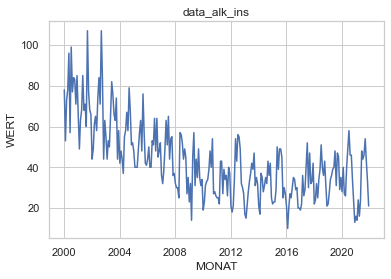

In [6]:
sns.set(rc={'figure.figsize':(8, 4)})
sns.set_style("whitegrid")

sns.lineplot(x='MONAT', y='WERT', data=df_list[0]).set_title('data_alk_ins')
plt.show()

Split data into train(<=2020) and test(>2020) set.

In [7]:
data = df_list[0].copy()
data.columns = ['ds', 'y']

data_train_val = data[data['ds'] < '2021-01-01']
data_train_val.reset_index(drop=True, inplace=True)
print(data_train_val.shape)
data_test = data[data['ds'] >= '2021-01-01']
data_test.reset_index(drop=True, inplace=True)
print(data_test.shape)

(252, 2)
(12, 2)


Train model.

In [ ]:
model = NeuralProphet(yearly_seasonality=True, seasonality_mode='additive', normalize='minmax')

data_train, data_val = model.split_df(data_train_val, freq='MS', valid_p=0.1)
print("Dataset size:", len(data))
print("Train dataset size:", len(data_train))
print("Validation dataset size:", len(data_val))

model = model.add_country_holidays(country_name='DE')
model.set_plotting_backend('plotly-static')
metrics_train = model.fit(data_train, validation_df=data_val, freq='MS', batch_size=3, epochs=300, early_stopping=False, learning_rate=0.008, progress=False)

In [59]:
metrics_train

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,MAE,RMSE,Loss,RegLoss
0,61.989670,67.393929,0.246797,0.0,0,67.880737,72.934708,0.418956,0.0
1,55.698898,61.635494,0.215536,0.0,1,61.292412,66.479767,0.368672,0.0
2,49.713993,55.985882,0.185150,0.0,2,54.390202,59.614468,0.315791,0.0
3,43.676952,50.761890,0.157301,0.0,3,47.478622,52.238735,0.264539,0.0
4,38.025879,45.479130,0.132150,0.0,4,40.557106,44.614979,0.214129,0.0
...,...,...,...,...,...,...,...,...,...
295,8.826751,10.850057,0.010427,0.0,295,5.457332,6.342604,0.006478,0.0
296,8.820773,10.840762,0.010409,0.0,296,5.463852,6.521655,0.006491,0.0
297,8.827985,10.843751,0.010414,0.0,297,5.458717,6.362125,0.006478,0.0
298,8.839818,10.856572,0.010439,0.0,298,5.461773,6.472795,0.006481,0.0


Visualize training and validation loss.

Text(0, 0.5, 'Loss')

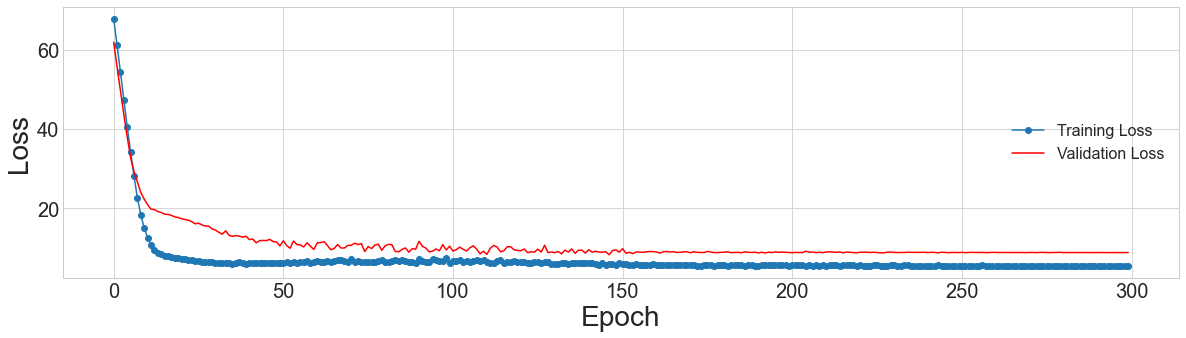

In [60]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(metrics_train["MAE"], '-o', label="Training Loss")  
ax.plot(metrics_train["MAE_val"], '-r', label="Validation Loss")
ax.legend(loc='center right', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel("Epoch", fontsize=28)
ax.set_ylabel("Loss", fontsize=28)

Test eveluation.

INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 50.0% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 50.0% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


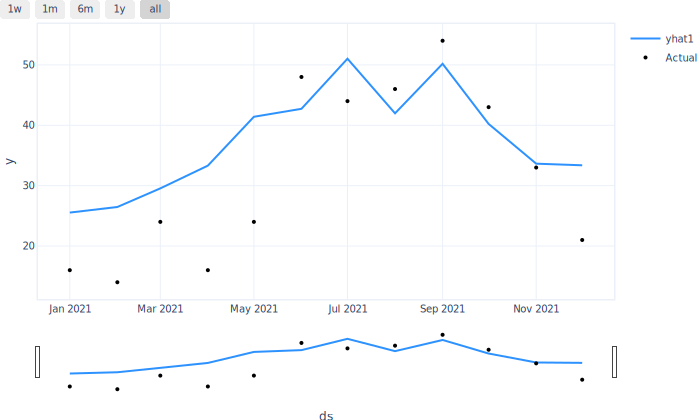

INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 50.0% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.016964124515652657
         MAE_val             8.183732032775879
        RMSE_val             9.786178588867188
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE_val,RMSE_val,Loss_test,RegLoss_test
0,8.183732,9.786179,0.016964,0.0


In [61]:
forecast = model.predict(data_test)
model.plot(forecast)

metrics_test = model.test(data_test)
metrics_test

Predict into future.

INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 57.937% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 52.899% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 52.899% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has m

            ds     y
0   2020-12-01  13.0
1   2020-11-01  23.0
2   2020-10-01  34.0
3   2020-09-01  46.0
4   2020-08-01  46.0
..         ...   ...
271 2022-08-01   NaN
272 2022-09-01   NaN
273 2022-10-01   NaN
274 2022-11-01   NaN
275 2022-12-01   NaN

[276 rows x 2 columns]
            ds     y      yhat1      trend  season_yearly
0   2020-12-01  13.0  32.028458  36.771217      -4.742760
1   2020-11-01  23.0  32.247116  36.659718      -4.412602
2   2020-10-01  34.0  38.829460  36.544502       2.284961
3   2020-09-01  46.0  48.754181  36.433006      12.321177
4   2020-08-01  46.0  40.674454  36.317787       4.356668
..         ...   ...        ...        ...            ...
271 2022-08-01   NaN  43.399937  39.030926       4.369011
272 2022-09-01   NaN  51.413284  39.146141      12.267142
273 2022-10-01   NaN  41.794117  39.257645       2.536474
274 2022-11-01   NaN  34.950935  39.372856      -4.421924
275 2022-12-01   NaN  34.797199  39.484356      -4.687160

[276 rows x 5 columns]


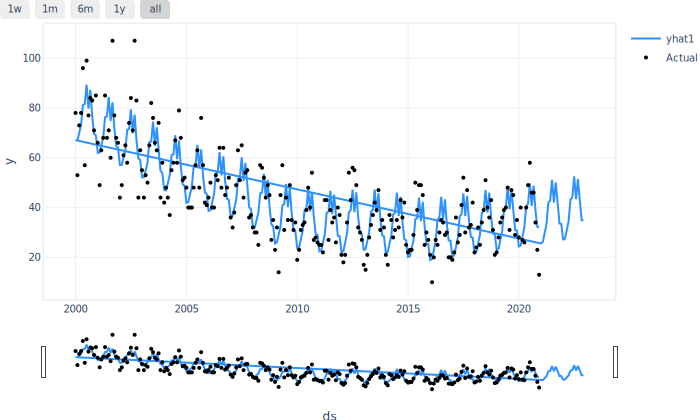

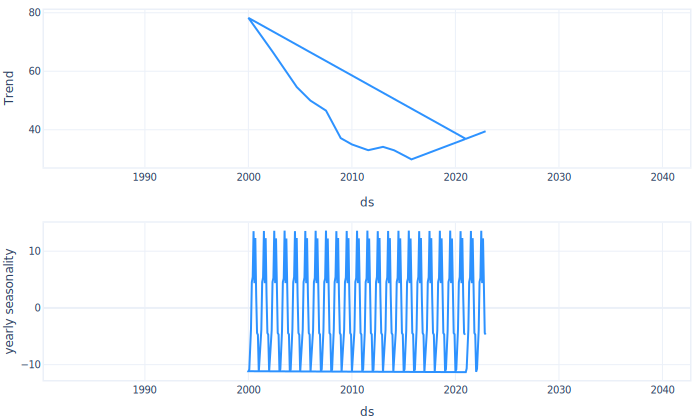

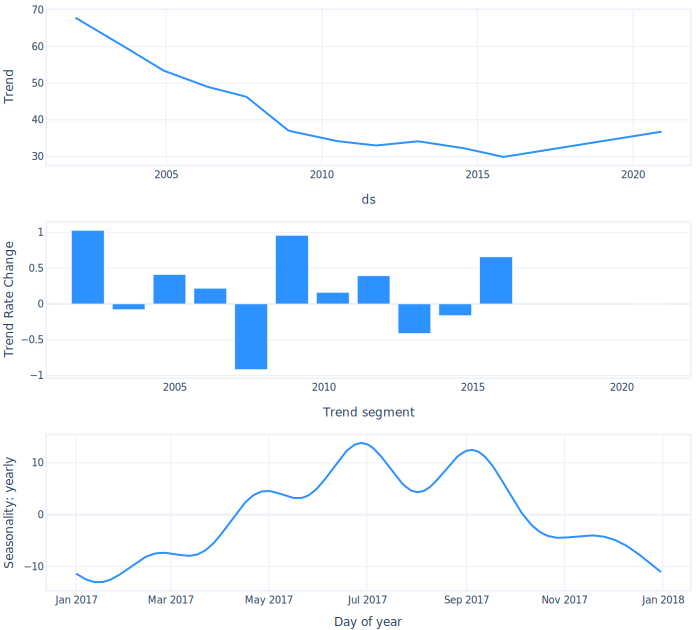

In [53]:
future = model.make_future_dataframe(data_train_val, periods=24, n_historic_predictions=len(data_train_val))
print(future)
forecast = model.predict(future)
print(forecast)

fig_forecast = model.plot(forecast)
fig_components = model.plot_components(forecast)
fig_model = model.plot_parameters()

Hyperparameter tuning using grid search.

In [17]:
model = NeuralProphet(yearly_seasonality=True, seasonality_mode='additive')
data_train, data_val = model.split_df(data_train_val, freq='MS', valid_p=0.1)
print("Dataset size:", len(data))
print("Train dataset size:", len(data_train))
print("Validation dataset size:", len(data_val))

param_grid = {  
    'learning_rate': [0.001, 0.008, 0.01, 0.1],
    'normalize': ['minmax', 'soft', 'standardize'],
    'epochs': [300],
    'batch_size': [3, 6, 12]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

maes_train = []; rmses_train = []; maes_val = []; rmses_val = []

for params in all_params:
    m = NeuralProphet(**params, yearly_seasonality=True, seasonality_mode='additive') 
    m = m.add_country_holidays(country_name='DE')
    m.set_plotting_backend('plotly-static')
    metrics_train = m.fit(data_train, validation_df=data_val, freq='MS', early_stopping=False, progress=False)
    maes_train.append(metrics_train['MAE'].values[-1])
    rmses_train.append(metrics_train['RMSE'].values[-1])
    maes_val.append(metrics_train['MAE_val'].values[-1])
    rmses_val.append(metrics_train['RMSE_val'].values[-1])
    print(params)
    print('training MAE:' + str(metrics_train['MAE'].values[-1]))
    print('training RMSE:' + str(metrics_train['RMSE'].values[-1]))
    print('validation MAE:' + str(metrics_train['MAE_val'].values[-1]))
    print('validation RMSE:' + str(metrics_train['RMSE_val'].values[-1]))
    print('---------------------------------')
    
tuning_results = pd.DataFrame(all_params)
tuning_results['MAE_train'] = maes_train
tuning_results['RMSE_train'] = rmses_train
tuning_results['MAE_val'] = maes_val
tuning_results['RMSE_val'] = rmses_val
tuning_results.sort_values(by='MAE_train', ascending=True, inplace=True)
tuning_results.reset_index(drop=True, inplace=True)
print(tuning_results)

best_params = all_params[np.argmin(maes_train)]
print(best_params)

INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 57.937% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.


INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 57.709% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run Ne

Dataset size: 264
Train dataset size: 227
Validation dataset size: 25


WARNING - (py.warnings._showwarnmsg) - /u/halle/zhouni/home_at/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 57.709% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet 

{'learning_rate': 0.001, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 3}
training MAE:69.5574951171875
training RMSE:82.63329315185547
validation MAE:94.0250015258789
validation RMSE:112.41216278076172
---------------------------------


Save model.

In [62]:
with open('./models/neuralprophet/model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
with open('./model.pkl', 'rb') as f:
    model = pickle.load(f)
    model.restore_trainer()

WARNING - (py.warnings._showwarnmsg) - /u/halle/zhouni/home_at/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")



In [38]:
save(model, "./test_save_model.np")

In [8]:
model = load("./test_save_model.np")

WARNING - (py.warnings._showwarnmsg) - /u/halle/zhouni/home_at/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")



In [9]:
future = model.make_future_dataframe(data, periods=12)
forecast = model.predict(future)
forecast.head()

INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 57.955% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: 0it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,events_additive,event_Ascension Day,event_Ascension Day; Labor Day,event_Christmas Day,event_Easter Monday,event_German Unity Day,event_Good Friday,event_Labor Day,event_New Year's Day,event_Reformation Day,event_Second Day of Christmas,event_Whit Monday
0,2022-01-01,None,26.943470,36.103035,-28.444145,19.284582,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,19.284582,0.0,0.0,0.0
1,2022-02-01,None,27.589596,36.216389,-8.626792,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,2022-03-01,None,30.974096,36.318771,-5.344676,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,2022-04-01,None,34.519810,36.432129,-1.912321,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,2022-05-01,None,42.805275,36.541828,2.120008,4.143439,0.0,0.0,0.0,0.0,0.0,0.0,4.143439,0.000000,0.0,0.0,0.0


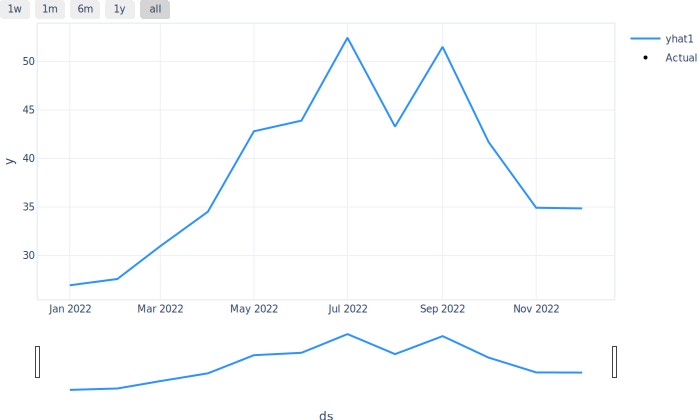

In [13]:
model.plot(forecast, plotting_backend='plotly-static')

Automated pipeline for all steps above.

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_3188650/3749644453.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_names[i+j-1].sort_values(by='MONAT', inplace=True, ascending=False)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_3188650/3749644453.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_names[i+j-1].sort_values(by='MONAT', inplace=True, ascending=False)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_3188650/3749644453.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

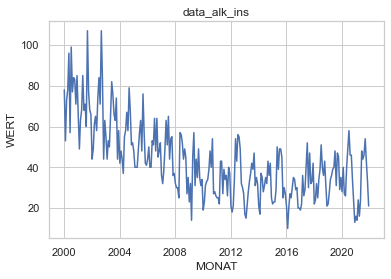

INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 57.937% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


(252, 2)
(12, 2)
Dataset size: 264
Train dataset size: 215
Validation dataset size: 37


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 57.674% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
WARNING - (py.warnings._showwarnmsg) - /u/halle/zhouni/home_at/.local/lib/python3.10/site-packages/torch/cud

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.032932061702013016
         MAE_val              8.4649658203125
        RMSE_val            10.120863914489746
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 3}
training MAE:5.329900741577148
training RMSE:6.150951385498047
validation MAE:11.162632942199707
validation RMSE:13.340224266052246
test MAE:8.4649658203125
test RMSE:10.120863914489746
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 50.0% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 57.674% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INF

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.028741205111145973
         MAE_val             8.161535263061523
        RMSE_val             9.45497989654541
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 6}
training MAE:5.546045780181885
training RMSE:6.807610988616943
validation MAE:20.253549575805664
validation RMSE:23.142494201660156
test MAE:8.161535263061523
test RMSE:9.45497989654541
---------------------------------


In [5]:
data = df.copy()

data_grouped = data.groupby(['MONATSZAHL', 'AUSPRAEGUNG'])

df_names = ['data_alk_ins', 'data_alk_vug', 'data_flu_ins', 'data_flu_vug', 'data_ver_ins', 'data_ver_mps', 'data_ver_vug']
df_list = []

for i in range(len(data.MONATSZAHL.unique())):
    data_tmp = data[data['MONATSZAHL'] == data.MONATSZAHL.unique()[i]]
    for j in range(len(data_tmp.AUSPRAEGUNG.unique())):
        data_tmp_2 = data_grouped.get_group((data.MONATSZAHL.unique()[i], data_tmp.AUSPRAEGUNG.unique()[j]))
        df_names[i+j-1] = data_tmp_2[['MONAT', 'WERT']]
        df_names[i+j-1].sort_values(by='MONAT', inplace=True, ascending=False)
        df_names[i+j-1].reset_index(drop=True, inplace=True)
        df_list.append(df_names[i+j-1])

sns.set(rc={'figure.figsize':(8, 4)})
sns.set_style("whitegrid")

df_names = ['data_alk_ins', 'data_alk_vug', 'data_flu_ins', 'data_flu_vug', 'data_ver_ins', 'data_ver_mps', 'data_ver_vug']

#logging.basicConfig(filename='./train_log/neuralprophet/' + df_names[i][5:] + '.log', encoding='utf-8', level=logging.INFO)
#logging.basicConfig(filename='./train_log/neuralprophet/train.log', encoding='utf-8', level=logging.INFO)
logger = logging.getLogger(__name__)

for i in range(len(df_list)):
    
    
    sns.lineplot(x='MONAT', y='WERT', data=df_list[i]).set_title(df_names[i])
    plt.savefig('./train_log/neuralprophet/' + df_names[i] +'.png')
    plt.show()
    
    data = df_list[i].copy()
    data.columns = ['ds', 'y']
    
    data_train_val = data[data['ds'] < '2021-01-01']
    data_train_val.reset_index(drop=True, inplace=True)
    logger.info(data_train_val.shape)
    print(data_train_val.shape)
    data_test = data[data['ds'] >= '2021-01-01']
    data_test.reset_index(drop=True, inplace=True)
    logger.info(data_test.shape)
    print(data_test.shape)
    
    model = NeuralProphet(yearly_seasonality=True, seasonality_mode='additive')
    data_train, data_val = model.split_df(data_train_val, freq='MS', valid_p=0.15)
    logger.info("Dataset size:" + str(len(data)))
    logger.info("Train dataset size:" + str(len(data_train)))
    logger.info("Validation dataset size:"+ str(len(data_val)))
    print("Dataset size:", len(data))
    print("Train dataset size:", len(data_train))
    print("Validation dataset size:", len(data_val))

    param_grid = {  
        'learning_rate': [0.001, 0.008, 0.01, 0.1],
        'normalize': ['minmax', 'soft', 'standardize'],
        'epochs': [300],
        'batch_size': [3, 6, 12]
    }

    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

    maes_train = []; rmses_train = []; maes_val = []; rmses_val = []; maes_test = []; rmses_test = []

    for params in all_params:
        m = NeuralProphet(**params, yearly_seasonality=True, seasonality_mode='additive') 
        m = m.add_country_holidays(country_name='DE')
        m.set_plotting_backend('plotly-static')
        metrics_train = m.fit(data_train, validation_df=data_val, freq='MS', early_stopping=False, progress=False)
        maes_train.append(metrics_train['MAE'].values[-1])
        rmses_train.append(metrics_train['RMSE'].values[-1])
        maes_val.append(metrics_train['MAE_val'].values[-1])
        rmses_val.append(metrics_train['RMSE_val'].values[-1])
        metrics_test = m.test(data_test)
        maes_test.append(metrics_test['MAE_val'].values[-1])
        rmses_test.append(metrics_test['RMSE_val'].values[-1])
        logger.info(params)
        logger.info('training MAE:' + str(metrics_train['MAE'].values[-1]))
        logger.info('training RMSE:' + str(metrics_train['RMSE'].values[-1]))
        logger.info('validation MAE:' + str(metrics_train['MAE_val'].values[-1]))
        logger.info('validation RMSE:' + str(metrics_train['RMSE_val'].values[-1]))
        logger.info('test MAE:' + str(metrics_test['MAE_val'].values[-1]))
        logger.info('test RMSE:' + str(metrics_test['RMSE_val'].values[-1]))
        logger.info('---------------------------------')
        print(params)
        print('training MAE:' + str(metrics_train['MAE'].values[-1]))
        print('training RMSE:' + str(metrics_train['RMSE'].values[-1]))
        print('validation MAE:' + str(metrics_train['MAE_val'].values[-1]))
        print('validation RMSE:' + str(metrics_train['RMSE_val'].values[-1]))
        print('test MAE:' + str(metrics_test['MAE_val'].values[-1]))
        print('test RMSE:' + str(metrics_test['RMSE_val'].values[-1]))
        print('---------------------------------')
        
    tuning_results = pd.DataFrame(all_params)
    tuning_results['MAE_train'] = maes_train
    tuning_results['RMSE_train'] = rmses_train
    tuning_results['MAE_val'] = maes_val
    tuning_results['RMSE_val'] = rmses_val
    tuning_results['MAE_test'] = maes_test
    tuning_results['RMSE_test'] = rmses_test
    tuning_results.sort_values(by='RMSE_test', ascending=True, inplace=True)
    tuning_results.reset_index(drop=True, inplace=True)
    logger.info(tuning_results)
    print(tuning_results)

    best_params = all_params[np.argmin(rmses_test)]
    logger.info(best_params)
    print(best_params)
    
    model = NeuralProphet(**best_params, yearly_seasonality=True, seasonality_mode='additive') 
    model = model.add_country_holidays(country_name='DE')
    model.set_plotting_backend('plotly-static')
    metrics_train = model.fit(data_train, validation_df=data_val, freq='MS', early_stopping=False, progress=False)
    logger.info(metrics_train)
    print(metrics_train)
    
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(metrics_train["MAE"], '-o', label="Training Loss")  
    ax.plot(metrics_train["MAE_val"], '-r', label="Validation Loss")
    ax.legend(loc='center right', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel("Epoch", fontsize=28)
    ax.set_ylabel("Loss", fontsize=28)
    plt.savefig('./train_log/neuralprophet/loss_' + df_names[i][5:] +'.png')
    plt.show()
    
    forecast = model.predict(data_test)
    model.plot(forecast)

    metrics_test = model.test(data_test)
    logger.info(metrics_test)
    print(metrics_test)
    
    forecast = model.predict(data_test)
    model.plot(forecast)
    #plt.savefig('./train_log/neuralprophet/forecast_' + df_names[i][5:] +'.png')

    metrics_test = model.test(data_test)
    logger.info(metrics_test)
    print(metrics_test)
    
    future = model.make_future_dataframe(data_train_val, periods=24, n_historic_predictions=len(data_train_val))
    logger.info(future)
    print(future)
    forecast = model.predict(future)
    logger.info(forecast)
    print(forecast)

    fig_forecast = model.plot(forecast)
    fig_components = model.plot_components(forecast)
    fig_model = model.plot_parameters()
    
    save(model, './models/neuralprophet/model_' + df_names[i][5:] +'.np')
    logger.info('model_'+ df_names[i][5:] +' saved.')

2. Machine Learning model (XGBoost).